# Assignment 4 - Average Reward Softmax Actor-Critic

 1. Implement softmax actor-critic agent on a continuing task using the average reward formulation.
 1. Understand how to parameterize the policy as a function to learn, in a discrete action environment.
 1. Understand how to (approximately) sample the gradient of this objective to update the actor.
 1. Understand how to update the critic using differential TD error.

## Pendulum Swing-Up Environment

Pendulum Swing-Up Environment

In this assignment, we will be using a Pendulum environment, adapted from Santamaría et al. (1998). This is also the same environment that we used in the lecture. The diagram below illustrates the environment.

The environment consists of single pendulum that can swing 360 degrees. The pendulum is actuated by applying a torque on its pivot point. The goal is to get the pendulum to balance up-right from its resting position (hanging down at the bottom with no velocity) and maintain it as long as possible. The pendulum can move freely, subject only to gravity and the action applied by the agent.

The state is 2-dimensional, which consists of the current angle $\beta \in [-\pi, \pi]$ (angle from the vertical upright position) and current angular velocity $\dot{\beta} \in (-2\pi, 2\pi)$. The angular velocity is constrained in order to avoid damaging the pendulum system. If the angular velocity reaches this limit during simulation, the pendulum is reset to the resting position. The action is the angular acceleration, with discrete values $a \in \{-1, 0, 1\}$ applied to the pendulum. For more details on environment dynamics you can refer to the original paper.

The goal is to swing-up the pendulum and maintain its upright angle. Hence, the reward is the negative absolute angle from the vertical position: $R_{t} = -|\beta_{t}|$

Furthermore, since the goal is to reach and maintain a vertical position, there are no terminations nor episodes. Thus this problem can be formulated as a continuing task.

Similar to the Mountain Car task, the action in this pendulum environment is not strong enough to move the pendulum directly to the desired position. The agent must learn to first move the pendulum away from its desired position and gain enough momentum to successfully swing-up the pendulum. And even after reaching the upright position the agent must learn to continually balance the pendulum in this unstable position.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm import tqdm
from rl_glue import RLGlue
from pendulum_env import PendulumEnvironment
from agent import BaseAgent
import plot_script
import tiles3 as tc

 ## Section 1: Create Tile Coding Helper Function
 In this section, we are going to build a tile coding class for our agent that will make it easier to make calls to our tile coder.

Tile-coding is introduced in Section 9.5.4 of the textbook as a way to create features that can both provide good generalization and discrimination. We have already used it in our last programming assignment as well.

Similar to the last programming assignment, we are going to make a function specific for tile coding for our Pendulum Swing-up environment. We will also use the Tiles3 library.

To get the tile coder working we need to:

 1. create an index hash table using tc.IHT(), 
 1. scale the inputs for the tile coder based on number of tiles and range of values each input could take
 1. call tc.tileswrap to get active tiles back.

However, we need to make one small change to this tile coder. Note that in this environment the state space contains angle, which is between $[-\pi, \pi]$. If we tile-code this state space in the usual way, the agent may think the value of states corresponding to an angle of $-\pi$ is very different from angle of $\pi$ when in fact they are the same! To remedy this and allow generalization between angle $= -\pi$ and angle $= \pi$, we need to use wrap tile coder.

In [2]:
class PendulumTileCoder:
    def __init__(self, iht_size=4096, num_tilings=32, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the tiles are the same
                            
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles 
        self.iht = tc.IHT(iht_size)
        
    def get_tiles(self, angle, ang_vel):
        """
        Takes in an angle and angular velocity from the pendulum environment
        and returns a numpy array of active tiles.
        
        Arguments:
        angle -- float, the angle of the pendulum between -np.pi and np.pi
        ang_vel -- float, the angular velocity of the agent between -2*np.pi and 2*np.pi
        
        returns:
        tiles -- np.array, active tiles
        
        """
        ANGLE_MIN = -np.pi
        ANGLE_MAX = np.pi
        ANG_VEL_MIN = -2 * np.pi
        ANG_VEL_MAX = 2 * np.pi
        
        angle_scale = self.num_tiles / (ANGLE_MAX - ANGLE_MIN)
        ang_vel_scale = self.num_tiles / (ANG_VEL_MAX - ANG_VEL_MIN)
        
        tiles = tc.tileswrap(self.iht, self.num_tilings, [angle * angle_scale, ang_vel * ang_vel_scale], wrapwidths=[self.num_tiles, False])
        
        return np.array(tiles)

In [3]:
## Test Code for PendulumTileCoder ##
# Your tile coder should also work for other num. tilings and num. tiles
test_obs = [[-np.pi, 0], [-np.pi, 0.5], [np.pi, 0], [np.pi, -0.5], [0, 1]]

pdtc = PendulumTileCoder(iht_size=4096, num_tilings=8, num_tiles=4)

result=[]
for obs in test_obs:
    angle, ang_vel = obs
    tiles = pdtc.get_tiles(angle=angle, ang_vel=ang_vel)
    result.append(tiles)
    
for tiles in result:
    print(tiles)

[0 1 2 3 4 5 6 7]
[0 1 2 3 4 8 6 7]
[0 1 2 3 4 5 6 7]
[ 9  1  2 10  4  5  6  7]
[11 12 13 14 15 16 17 18]


## Section 2: Create Average Reward Softmax Actor-Critic Agent

This agent has two components: an Actor and a Critic. The Actor learns a parameterized policy while the Critic learns a state-value function. The environment has discrete actions; your Actor implementation will use a softmax policy with exponentiated action-preferences. The Actor learns with the sample-based estimate for the gradient of the average reward objective. The Critic learns using the average reward version of the semi-gradient TD(0) algorithm.

In [4]:
def compute_softmax_prob(actor_w, tiles):
    """
    Computes softmax probability for all actions
    
    Args:
    actor_w - np.array, an array of actor weights
    tiles - np.array, an array of active tiles
    
    Returns:
    softmax_prob - np.array, an array of size equal to num. actions, and sums to 1.
    """
    state_action_preferences = []
    state_action_preferences = actor_w[:, tiles].sum(axis=1)
    c = np.max(state_action_preferences)
    numerator = np.exp(state_action_preferences - c)
    denominator = np.sum(numerator)
    softmax_prob = numerator / denominator
    
    return softmax_prob

In [5]:
## Test Code for compute_softmax_prob() ##

# set tile-coder
iht_size = 4096
num_tilings = 8
num_tiles = 8
test_tc = PendulumTileCoder(iht_size=iht_size, num_tilings=num_tilings, num_tiles=num_tiles)

num_actions = 3
actions = list(range(num_actions))
actor_w = np.zeros((len(actions), iht_size))

# setting actor weights such that state-action preferences are always [-1, 1, 2]
actor_w[0] = -1./num_tilings
actor_w[1] = 1./num_tilings
actor_w[2] = 2./num_tilings

# obtain active_tiles from state
state = [-np.pi, 0.]
angle, ang_vel = state
active_tiles = test_tc.get_tiles(angle, ang_vel)

# compute softmax probability
softmax_prob = compute_softmax_prob(actor_w, active_tiles) 
print('softmax probability: {}'.format(softmax_prob))

softmax probability: [0.03511903 0.25949646 0.70538451]


In [8]:
class ActorCriticSoftmaxAgent(BaseAgent): 
    def __init__(self):
        self.rand_generator = None

        self.actor_step_size = None
        self.critic_step_size = None
        self.avg_reward_step_size = None

        self.tc = None

        self.avg_reward = None
        self.critic_w = None
        self.actor_w = None

        self.actions = None

        self.softmax_prob = None
        self.prev_tiles = None
        self.last_action = None
    
    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the semi-gradient TD(0) state aggregation agent.

        Assume agent_info dict contains:
        {
            "iht_size": int
            "num_tilings": int,
            "num_tiles": int,
            "actor_step_size": float,
            "critic_step_size": float,
            "avg_reward_step_size": float,
            "num_actions": int,
            "seed": int
        }
        """

        self.rand_generator = np.random.RandomState(agent_info.get("seed")) 

        iht_size = agent_info.get("iht_size")
        num_tilings = agent_info.get("num_tilings")
        num_tiles = agent_info.get("num_tiles")

        self.tc = PendulumTileCoder(iht_size=iht_size, num_tilings=num_tilings, num_tiles=num_tiles)

        self.actor_step_size = agent_info.get("actor_step_size")/num_tilings
        self.critic_step_size = agent_info.get("critic_step_size")/num_tilings
        self.avg_reward_step_size = agent_info.get("avg_reward_step_size")

        self.actions = list(range(agent_info.get("num_actions")))

        self.avg_reward = 0.0
        self.actor_w = np.zeros((len(self.actions), iht_size))
        self.critic_w = np.zeros(iht_size)

        self.softmax_prob = None
        self.prev_tiles = None
        self.last_action = None
    
    def agent_policy(self, active_tiles):
        """ policy of the agent
        Args:
            active_tiles (Numpy array): active tiles returned by tile coder
            
        Returns:
            The action selected according to the policy
        """
        
        softmax_prob = compute_softmax_prob(self.actor_w, active_tiles)
        
        chosen_action = self.rand_generator.choice(self.actions, p=softmax_prob)
        
        self.softmax_prob = softmax_prob
        
        return chosen_action

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the environment's env_start function.
        Returns:
            The first action the agent takes.
        """

        angle, ang_vel = state


        active_tiles = self.tc.get_tiles(angle, ang_vel)
        current_action = self.agent_policy(active_tiles)
        self.last_action = current_action
        self.prev_tiles = np.copy(active_tiles)

        return self.last_action


    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the environment's step based on 
                                where the agent ended up after the
                                last step.
        Returns:
            The action the agent is taking.
        """

        angle, ang_vel = state

        active_tiles = self.tc.get_tiles(angle, ang_vel)
        delta = reward - self.avg_reward + self.critic_w[active_tiles].sum() - self.critic_w[self.prev_tiles].sum()

        self.avg_reward += self.avg_reward_step_size * delta
        self.critic_w[self.prev_tiles] += self.critic_step_size * delta
        for a in self.actions:
            if a == self.last_action:
                self.actor_w[a][self.prev_tiles] += self.actor_step_size * delta * (1 - self.softmax_prob[a])
            else:
                self.actor_w[a][self.prev_tiles] += self.actor_step_size * delta * (0 - self.softmax_prob[a])

        current_action = self.agent_policy(active_tiles)

        self.prev_tiles = active_tiles
        self.last_action = current_action

        return self.last_action


    def agent_message(self, message):
        if message == 'get avg reward':
            return self.avg_reward

In [9]:
## Test Code for agent_start()## 

agent_info = {"iht_size": 4096,
              "num_tilings": 8,
              "num_tiles": 8,
              "actor_step_size": 1e-1,
              "critic_step_size": 1e-0,
              "avg_reward_step_size": 1e-2,
              "num_actions": 3,
              "seed": 99}

test_agent = ActorCriticSoftmaxAgent()
test_agent.agent_init(agent_info)

state = [-np.pi, 0.]

test_agent.agent_start(state)

print("agent active_tiles: {}".format(test_agent.prev_tiles))
print("agent selected action: {}".format(test_agent.last_action))

agent active_tiles: [0 1 2 3 4 5 6 7]
agent selected action: 2


In [10]:
## Test Code for agent_step() ## 
# Make sure agent_start() and agent_policy() are working correctly first.
# agent_step() should work correctly for other arbitrary state transitions in addition to this test case.

env_info = {"seed": 99}
agent_info = {"iht_size": 4096,
              "num_tilings": 8,
              "num_tiles": 8,
              "actor_step_size": 1e-1,
              "critic_step_size": 1e-0,
              "avg_reward_step_size": 1e-2,
              "num_actions": 3,
              "seed": 99}

test_env = PendulumEnvironment
test_agent = ActorCriticSoftmaxAgent

rl_glue = RLGlue(test_env, test_agent)
rl_glue.rl_init(agent_info, env_info)

# start env/agent
rl_glue.rl_start()
rl_glue.rl_step()

print("agent next_action: {}".format(rl_glue.agent.last_action))
print("agent avg reward: {}\n".format(rl_glue.agent.avg_reward))
print("agent first 10 values of actor weights[0]: \n{}\n".format(rl_glue.agent.actor_w[0][:10]))
print("agent first 10 values of actor weights[1]: \n{}\n".format(rl_glue.agent.actor_w[1][:10]))
print("agent first 10 values of actor weights[2]: \n{}\n".format(rl_glue.agent.actor_w[2][:10]))
print("agent first 10 values of critic weights: \n{}".format(rl_glue.agent.critic_w[:10]))

agent next_action: 1
agent avg reward: -0.03139092653589793

agent first 10 values of actor weights[0]: 
[0.01307955 0.01307955 0.01307955 0.01307955 0.01307955 0.01307955
 0.01307955 0.01307955 0.         0.        ]

agent first 10 values of actor weights[1]: 
[0.01307955 0.01307955 0.01307955 0.01307955 0.01307955 0.01307955
 0.01307955 0.01307955 0.         0.        ]

agent first 10 values of actor weights[2]: 
[-0.02615911 -0.02615911 -0.02615911 -0.02615911 -0.02615911 -0.02615911
 -0.02615911 -0.02615911  0.          0.        ]

agent first 10 values of critic weights: 
[-0.39238658 -0.39238658 -0.39238658 -0.39238658 -0.39238658 -0.39238658
 -0.39238658 -0.39238658  0.          0.        ]


## Section 3: Run Experiment

In [11]:
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):

    rl_glue = RLGlue(environment, agent)
            
    # sweep agent parameters
    for num_tilings in agent_parameters['num_tilings']:
        for num_tiles in agent_parameters["num_tiles"]:
            for actor_ss in agent_parameters["actor_step_size"]:
                for critic_ss in agent_parameters["critic_step_size"]:
                    for avg_reward_ss in agent_parameters["avg_reward_step_size"]:
                        
                        env_info = {}
                        agent_info = {"num_tilings": num_tilings,
                                      "num_tiles": num_tiles,
                                      "actor_step_size": actor_ss,
                                      "critic_step_size": critic_ss,
                                      "avg_reward_step_size": avg_reward_ss,
                                      "num_actions": agent_parameters["num_actions"],
                                      "iht_size": agent_parameters["iht_size"]}            
            
                        return_per_step = np.zeros((experiment_parameters["num_runs"], experiment_parameters["max_steps"]))
                        exp_avg_reward_per_step = np.zeros((experiment_parameters["num_runs"], experiment_parameters["max_steps"]))

                        for run in tqdm(range(1, experiment_parameters["num_runs"]+1)):
                            env_info["seed"] = run
                            agent_info["seed"] = run
                
                            rl_glue.rl_init(agent_info, env_info)
                            rl_glue.rl_start()

                            num_steps = 0
                            total_return = 0.
                            return_arr = []

                            exp_avg_reward = 0.0
                            exp_avg_reward_ss = 0.01
                            exp_avg_reward_normalizer = 0

                            while num_steps < experiment_parameters['max_steps']:
                                num_steps += 1
                                
                                rl_step_result = rl_glue.rl_step()
                                
                                reward = rl_step_result[0]
                                total_return += reward
                                return_arr.append(reward)
                                avg_reward = rl_glue.rl_agent_message("get avg reward")

                                exp_avg_reward_normalizer = exp_avg_reward_normalizer + exp_avg_reward_ss * (1 - exp_avg_reward_normalizer)
                                ss = exp_avg_reward_ss / exp_avg_reward_normalizer
                                exp_avg_reward += ss * (reward - exp_avg_reward)
                                
                                return_per_step[run-1][num_steps-1] = total_return
                                exp_avg_reward_per_step[run-1][num_steps-1] = exp_avg_reward
                                                        
                        if not os.path.exists('results'):
                            os.makedirs('results')
                
                        save_name = "ActorCriticSoftmax_tilings_{}_tiledim_{}_actor_ss_{}_critic_ss_{}_avg_reward_ss_{}".format(num_tilings, num_tiles, actor_ss, critic_ss, avg_reward_ss)
                        total_return_filename = "results/{}_total_return.npy".format(save_name)
                        exp_avg_reward_filename = "results/{}_exp_avg_reward.npy".format(save_name)

                        np.save(total_return_filename, return_per_step)
                        np.save(exp_avg_reward_filename, exp_avg_reward_per_step)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [08:52<00:00, 10.64s/it]


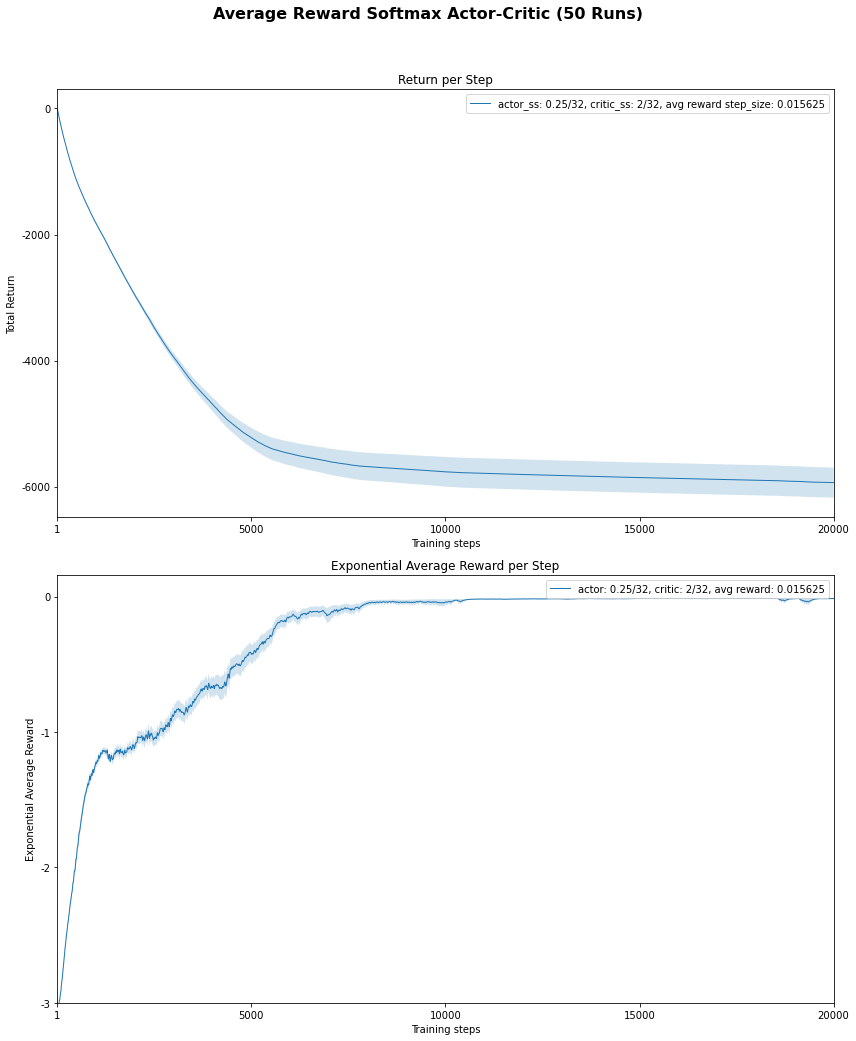

In [12]:
#### Run Experiment

# Experiment parameters
experiment_parameters = {
    "max_steps" : 20000,
    "num_runs" : 50
}

# Environment parameters
environment_parameters = {}

# Agent parameters
# Each element is an array because we will be later sweeping over multiple values
# actor and critic step-sizes are divided by num. tilings inside the agent
agent_parameters = {
    "num_tilings": [32],
    "num_tiles": [8],
    "actor_step_size": [2**(-2)],
    "critic_step_size": [2**1],
    "avg_reward_step_size": [2**(-6)],
    "num_actions": 3,
    "iht_size": 4096
}

current_env = PendulumEnvironment
current_agent = ActorCriticSoftmaxAgent


run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_script.plot_result(agent_parameters, 'results')